# Setup

### Model decisions

In [48]:
# Weights and Biases
!pip install -q wandb
# Tensorflow
!pip install -q tensorflow

In [49]:
previous_loading = False
google_colab = False
moneyness = False
lags = 140
hyperparameter_search = False
training_size = 991232
random_seed = 0
finance_computers = False
fc_path = 'M:/Master/'

### Imports

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import wandb

from datetime import datetime
from dateutil.relativedelta import relativedelta


from math import log
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error

# Load, split and normalize data

### Load data

In [51]:
file = "../data/processed_data/2010-2023_NSS_filtered_vF.csv"
df_read = pd.read_csv(file)

display(df_read)


,Unnamed: 0,Quote_date,Price,Underlying_last,Strike,TTM,R
0,0,2010-01-04,207.490,1132.99,925.0,0.008219,0.00050
1,1,2010-01-04,182.500,1132.99,950.0,0.008219,0.00050
2,2,2010-01-04,157.500,1132.99,975.0,0.008219,0.00050
3,3,2010-01-04,132.600,1132.99,1000.0,0.008219,0.00050
4,4,2010-01-04,107.705,1132.99,1025.0,0.008219,0.00050
...,...,...,...,...,...,...,...
12057638,13739049,2023-03-31,217.750,4109.88,4700.0,1.726027,0.04198
12057639,13739050,2023-03-31,180.000,4109.88,4800.0,1.726027,0.04198
12057640,13739051,2023-03-31,146.550,4109.88,4900.0,1.726027,0.04198
12057641,13739052,2023-03-31,118.200,4109.88,5000.0,1.726027,0.04198


### Create lags

In [52]:
df = df_read
del df_read

if hyperparameter_search:
    df = df[df['Quote_date'] <= '2015-02-01']

# Filter df between 2014-01-01 and 2022-12-31
df = df[(df["Quote_date"] >= "2011-09-01") & (df["Quote_date"] <= "2015-01-01")]

# Group the data by Quote Date and calculate the mean for Underlying Price
df_agg = df.groupby('Quote_date').mean().reset_index()

# Values to returns
df_agg["Underlying_return"] = df_agg["Underlying_last"].pct_change()

# Add the Underlying Price Lag column
for i in range(1, lags + 1):
    df_agg['Underlying_' + str(i)] = df_agg['Underlying_return'].shift(i)

df = pd.merge(df, df_agg[['Quote_date', 'Underlying_return'] + ['Underlying_' + str(i) for i in range(1, lags + 1)]], on='Quote_date', how='left')



print(df)

/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_4306/166589780.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['Underlying_' + str(i)] = df_agg['Underlying_return'].shift(i)
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_4306/166589780.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['Underlying_' + str(i)] = df_agg['Underlying_return'].shift(i)
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_4306/166589780.py:18: PerformanceWarning: DataFrame is highly fragmented.  This i

         Unnamed: 0  Quote_date    Price  Underlying_last  Strike       TTM  \
0            381812  2011-09-01  304.355          1203.96   900.0  0.002740   
1            381813  2011-09-01  279.345          1203.96   925.0  0.002740   
2            381814  2011-09-01  254.355          1203.96   950.0  0.002740   
3            381815  2011-09-01  229.350          1203.96   975.0  0.002740   
4            381816  2011-09-01  204.350          1203.96  1000.0  0.002740   
...             ...         ...      ...              ...     ...       ...   
1225372     1808951  2014-12-31   45.650          2059.12  2450.0  1.958904   
1225373     1808952  2014-12-31   40.350          2059.12  2475.0  1.958904   
1225374     1808953  2014-12-31   35.555          2059.12  2500.0  1.958904   
1225375     1808954  2014-12-31   31.245          2059.12  2525.0  1.958904   
1225376     1808955  2014-12-31   27.350          2059.12  2550.0  1.958904   

                R  Underlying_return  Underlying_1 

### Format input data

In [53]:
# Format settings
max_timesteps = lags
bs_vars = ['Moneyness', 'TTM', 'R'] if moneyness else ['Underlying_last', 'Strike', 'TTM', 'R']
underlying_lags = [f'Underlying_{i}' for i in range (max_timesteps - 1, 0, -1)] + ['Underlying_return']

def create_rw_dataset(window_number = 0, df = None):
    '''Creates dataset for a single rolling window period offsett by the window number'''

    # Create train, validation and test set split points
    test_months = 3
    train_start = datetime(2011,9,1) + relativedelta(months=window_number * test_months)
    val_start = train_start + relativedelta(months=3*12)
    test_start = val_start + relativedelta(months = 1 + test_months) if hyperparameter_search else val_start + relativedelta(months = 1)
    test_end = test_start + relativedelta(months=test_months)
    train_start = str(train_start.date())
    val_start = str(val_start.date())
    test_start = str(test_start.date())
    test_end = str(test_end.date())

        
    # Split train and validation data
    df_train = df[(df['Quote_date'] >= train_start) & (df['Quote_date'] < val_start)]
    df_val = df[(df['Quote_date'] >= val_start) & (df['Quote_date'] < test_start)]
    df_test = df[(df['Quote_date'] >= test_start) & (df['Quote_date'] < test_end)]

    del df

    # Extract target values
    train_y = (df_train['Price'] / df_train['Strike']).to_numpy() if moneyness else df_train['Price'].to_numpy()
    val_y = (df_val['Price'] / df_val['Strike']).to_numpy() if moneyness else df_val['Price'].to_numpy()
    test_y = (df_test['Price'] / df_test['Strike']).to_numpy() if moneyness else df_test['Price'].to_numpy()

    # If usining moneyness, extract strike
    if moneyness:
        train_strike = df_train['Strike'].to_numpy()
        val_strike = df_val['Strike'].to_numpy()
        test_strike = df_test['Strike'].to_numpy()


    # Print earliest and latest date in every dataframe used
    print("--------------Dataframe dates--------------")
    print(f"Train: {df_train['Quote_date'].min()} - {df_train['Quote_date'].max()}")
    print(f"Val: {df_val['Quote_date'].min()} - {df_val['Quote_date'].max()}")
    print(f"Test: {df_test['Quote_date'].min()} - {df_test['Quote_date'].max()}")
    print("-------------------------------------------")

    # Convert dataframes to numpy arrays
    train_x = [df_train[underlying_lags].to_numpy(), df_train[bs_vars].to_numpy()]
    val_x = [df_val[underlying_lags].to_numpy(), df_val[bs_vars].to_numpy()]
    test_x = [df_test[underlying_lags].to_numpy(), df_test[bs_vars].to_numpy()]

    del df_train
    del df_val

    # Scale features based on training set
    underlying_scaler = MinMaxScaler()

    print("train_x[0]", train_x[0])
    print("train_x[0].flatten()", train_x[0].flatten())
    print("train_x[1]", train_x[1])
    train_x[0] = underlying_scaler.fit_transform(train_x[0].flatten().reshape(-1, 1)).reshape(train_x[0].shape)
    val_x[0] = underlying_scaler.transform(val_x[0].flatten().reshape(-1,1)).reshape(val_x[0].shape)
    test_x[0] = underlying_scaler.transform(test_x[0].flatten().reshape(-1,1)).reshape(test_x[0].shape)

    bs_scaler = MinMaxScaler()
    train_x[1] = bs_scaler.fit_transform(train_x[1])
    val_x[1] = bs_scaler.transform(val_x[1])
    test_x[1] = bs_scaler.transform(test_x[1])


    # Shuffle training set
    np.random.seed(random_seed)
    shuffle = np.random.permutation(len(train_x[0]))
    train_x = [train_x[0][shuffle], train_x[1][shuffle]]
    train_y = train_y[shuffle]

    # Extract training set
    train_x = [train_x[0][:training_size], train_x[1][:training_size]]
    train_y = train_y[:training_size]

    if moneyness:
        train_strike = train_strike[shuffle][:training_size]

    # Reshape data to fit LSTM
    train_x = [train_x[0].reshape(len(train_x[0]), max_timesteps, 1), train_x[1]]
    val_x = [val_x[0].reshape(len(val_x[0]), max_timesteps, 1), val_x[1]]
    test_x = [test_x[0].reshape(len(test_x[0]), max_timesteps, 1), test_x[1]]

    print(f'Train shape: {train_x[0].shape}, {train_x[1].shape}')
    print(f'Val shape: {val_x[0].shape}, {val_x[1].shape}')
    print(f'Test shape: {test_x[0].shape}, {test_x[1].shape}')

    if moneyness:
        return train_x, train_y, val_x, val_y, test_x, test_y, train_start, val_start, test_start, df_test, train_strike, val_strike, test_strike,
    return train_x, train_y, val_x, val_y, test_x, test_y, train_start, val_start, test_start, df_test

# Create the dataset for the first rolling window period
if moneyness:
    train_x, train_y, val_x, val_y, test_x, test_y, train_start, val_start, test_start, df_test, train_strike, val_strike, test_strike = create_rw_dataset(df=df)
else:
    train_x, train_y, val_x, val_y, test_x, test_y, train_start, val_start, test_start, df_test = create_rw_dataset(df=df)
    if hyperparameter_search:
        del df

--------------Dataframe dates--------------
Train: 2011-09-01 - 2014-08-29
Val: 2014-09-02 - 2014-09-30
Test: 2014-10-01 - 2014-12-31
-------------------------------------------
train_x[0] [[            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 ...
 [ 1.68091549e-03  1.09687385e-02 -1.48400572e-04 ... -7.99948003e-05
  -1.47502213e-03  3.18474527e-03]
 [ 1.68091549e-03  1.09687385e-02 -1.48400572e-04 ... -7.99948003e-05
  -1.47502213e-03  3.18474527e-03]
 [ 1.68091549e-03  1.09687385e-02 -1.48400572e-04 ... -7.99948003e-05
  -1.47502213e-03  3.18474527e-03]]
train_x[0].flatten() [            nan             nan             nan ... -7.99948003e-05
 -1.47502213e-03  3.18474527e-03]
train_x[1] [[1.20396000e+03 9.00000000e+02 2.739726

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def compute_saliency_map(model, input_data, percentage=0.02):
    n_samples = len(input_data[0])
    sample_size = int(n_samples * percentage)
    
    # Randomly select a subset of samples
    idx = np.random.choice(n_samples, sample_size, replace=False)
    input_data_underlying_sample = tf.convert_to_tensor(input_data[0][idx], dtype=tf.float32)
    input_data_bs_sample = tf.convert_to_tensor(input_data[1][idx], dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_data_underlying_sample)
        tape.watch(input_data_bs_sample)
        output = model([input_data_underlying_sample, input_data_bs_sample])

    grads = tape.gradient(output, [input_data_underlying_sample, input_data_bs_sample])
    grads_underlying = grads[0]
    grads_bs = grads[1]

    saliency_map_underlying = np.mean(np.abs(grads_underlying.numpy()), axis=0)
    saliency_map_bs = np.mean(np.abs(grads_bs.numpy()), axis=0)

    return saliency_map_underlying, saliency_map_bs


input_data = train_x


In [55]:
model = load_model(f'model3.h5')


In [56]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140, 1)]     0           []                               
                                                                                                  
 sequential (Sequential)        (None, 8)            512         ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                              

In [57]:
saliency_map_underlying, saliency_map_bs = compute_saliency_map(model, input_data)

In [58]:
print(f'saliency_map_underlying shape: {saliency_map_underlying.shape}')
print(f'saliency_map_bs shape: {saliency_map_bs.shape}')
saliency_map_bs = np.reshape(saliency_map_bs, (-1, 1))
print(f'saliency_map_bs shape: {saliency_map_bs.shape}')
print(saliency_map_bs)
print(saliency_map_underlying)

# Sum of saliency map for underlying
saliency_map_underlying_sum = np.sum(saliency_map_underlying)
print(f'The sum of the saliency map for the underlying lags is: {saliency_map_underlying_sum}')
# Sum of saliency map for bs
saliency_map_bs_sum = np.sum(saliency_map_bs)
print(f'The sum of the saliency map for the bs is: {saliency_map_bs_sum}')
print("The proportion of the saliency map for the underlying lags is: ", saliency_map_underlying_sum / (saliency_map_underlying_sum + saliency_map_bs_sum))

saliency_map_underlying shape: (140, 1)
saliency_map_bs shape: (4,)
saliency_map_bs shape: (4, 1)
[[ 612.9775  ]
 [1320.68    ]
 [ 183.6387  ]
 [  10.424567]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 

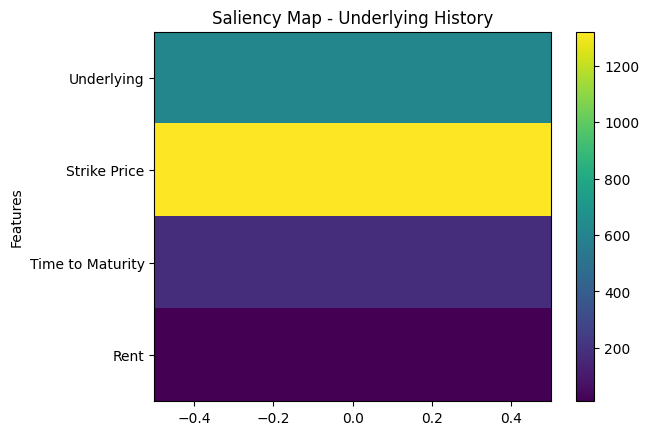

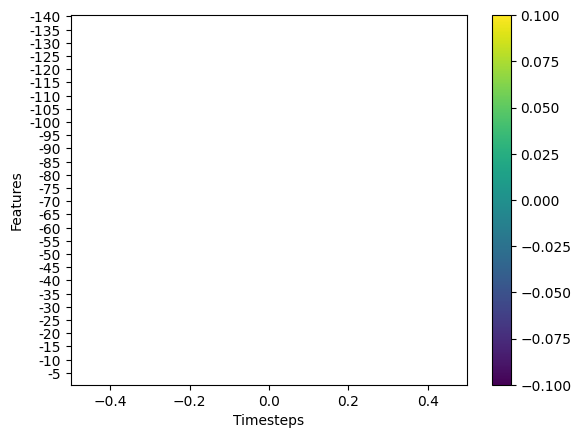

In [59]:
# Saliency map for underlying history
bs_variables = ['Underlying', 'Strike Price', 'Time to Maturity', 'Rent']
plt.imshow(saliency_map_bs, cmap='viridis', aspect='auto')
# Create axis ticks
ax = plt.gca()
plt.colorbar()
plt.yticks(range(len(bs_variables)), bs_variables)
plt.ylabel('Features')
plt.title('Saliency Map - Underlying History')
plt.show()

# Saliency map for underlying history
lag_steps = [x for x in range(-max_timesteps, 0)]
plt.imshow(saliency_map_underlying, cmap='viridis', aspect='auto')
plt.colorbar()
plt.yticks(range(len(lag_steps)), lag_steps)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.show()